## SteamGames
#### Sheida Majidi

# causal inference project

##### Objective
The primary objective of this project is to answer the causal question: "What is the effect of offering a game for free on the amount of peak concurrent users?" This involves comparing games offered for free (treatment group) against those that are paid (control group), taking into consideration various confounding factors that might influence both the likelihood of a game being offered for free and its peak CCU.

##### Key Components
- Target Variable: The target variable is "Peak CCU", representing the maximum number of users playing the game simultaneously at any given time. This metric serves as a proxy for game popularity and user engagement.
- Treatment: The treatment under consideration is whether a game is offered for free ("Price Category == free"). This binary variable distinguishes between the two groups of interest: games that are freely available and those that require payment to access.
- Control: The control group consists of games that are not offered for free ("Price Category == paid"), providing a baseline against which to measure the treatment's effect.
- Confounders: Several confounding variables are considered, including "Required age", "DLC count", "Average playtime forever", "Average playtime two weeks", "Median playtime forever", "Median playtime two weeks", "Categories", "Genres", and "Release year". These factors are controlled for in the analysis to isolate the effect of the treatment from other influences that might affect peak CCU.

##### Methodology
The project employs various causal inference techniques to estimate the causal effect, including:

- LRSRegressor: A linear regression model that estimates the causal effect of the treatment on the target variable, using confounders as control variables.
- XGBTRegressor: An XGBoost model that captures non-linear effects and interactions between variables, providing a more nuanced understanding of the treatment's impact.
- Meta-Learners: Various meta-learner models like S-Learner, T-Learner, and R-Learner are used to further dissect the causal relationships, offering insights into conditional average treatment effects (CATE) and average treatment effects (ATE) across different segments of the data.

In [1]:
import sys
import pandas as pd
import numpy as np
from packaging import version
import sklearn
import ast
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns
assert sys.version_info >= (3, 7)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression

### Load Data

In [2]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_games_data():
    tarball_path = Path("/Users/sheidamajidi/Desktop/Winter2024/COURSES/INSY695/Individual Assignments/ML1/games.csv")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://www.kaggle.com/datasets/mexwell/steamgames/data"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as games_tarball:
            games_tarball.extractall(path="datasets")
    return pd.read_csv(Path("/Users/sheidamajidi/Desktop/Winter2024/COURSES/INSY695/Individual Assignments/ML1/games.csv"))

games = load_games_data()

### Preprocess Data

In [3]:
games.head()

,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,About the game,Supported languages,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,Galactic Bowling is an exaggerated and stylize...,['English'],...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",...,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
3,1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
4,1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",...,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


#### Data Cleaning 

##### Handling missing values

In [4]:
# Dropping specified columns with more than 85% missing values
columns_to_drop = ['Reviews', 'Score rank', 'Metacritic url', 'Notes']
for column in columns_to_drop:
    if games[column].isnull().mean() > 0.85:
        games.drop(column, axis=1, inplace=True)

# Saving the modified dataset 
#games.to_csv("/Users/sheidamajidi/Desktop/Winter2024/COURSES/INSY695/Individual Assignments/ML1/SteamGames/games_cleaned.csv", index=False) 

In [5]:
# Impute missing values

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Select only numeric columns for imputation
numeric_cols = games.select_dtypes(include=[np.number])

iterative_imputer = IterativeImputer()
imputed_data = iterative_imputer.fit_transform(numeric_cols)

# Creating a DataFrame with the imputed data
imputed_df = pd.DataFrame(imputed_data, columns=numeric_cols.columns)

# Merging imputed numeric data back with non-numeric data
games[numeric_cols.columns] = imputed_df


In [6]:
# Select only numeric columns
numeric_columns = games.select_dtypes(include=[np.number]).columns

# Print the list of numeric columns
print("Numeric columns in the dataset:")
print(numeric_columns.tolist())

Numeric columns in the dataset:
['AppID', 'Peak CCU', 'Required age', 'Price', 'DLC count', 'Metacritic score', 'User score', 'Positive', 'Negative', 'Achievements', 'Recommendations', 'Average playtime forever', 'Average playtime two weeks', 'Median playtime forever', 'Median playtime two weeks']


##### Handling categorical columns

In [7]:
# Process the 'Suppported languages' column

from catboost import CatBoostRegressor

model = CatBoostRegressor(cat_features=['Supported languages'], random_state=42)

In [8]:
# Process the 'Full audio languages' column

# Function to convert list of languages into a single string
def concat_languages(lang_list):
    return ', '.join(lang_list) if isinstance(lang_list, list) else lang_list

# Apply the function to the 'Full audio languages' column
games['Full audio languages'] = games['Full audio languages'].apply(concat_languages)

# Prepare your features (X) and target (y)
numeric_cols = ['Required age', 'Price', 'DLC count', 
                'Metacritic score', 'User score', 'Positive', 'Negative', 
                'Achievements', 'Recommendations', 'Average playtime forever', 
                'Average playtime two weeks', 'Median playtime forever', 
                'Median playtime two weeks']

X = games[numeric_cols + ['Full audio languages']]
y = games['Peak CCU']

# Instantiate a CatBoost model
model = CatBoostRegressor(cat_features=['Full audio languages'], random_state=42)

# Fit the model
model.fit(X, y)


Learning rate set to 0.080421
0:	learn: 5731.8134970	total: 68.7ms	remaining: 1m 8s
1:	learn: 5624.9583838	total: 81.1ms	remaining: 40.5s
2:	learn: 5539.9867463	total: 103ms	remaining: 34.4s
3:	learn: 5418.0358263	total: 114ms	remaining: 28.4s
4:	learn: 5300.9617579	total: 120ms	remaining: 23.9s
5:	learn: 5247.5105625	total: 126ms	remaining: 20.8s
6:	learn: 5196.4251373	total: 131ms	remaining: 18.6s
7:	learn: 5146.7809174	total: 136ms	remaining: 16.8s
8:	learn: 5098.2620089	total: 142ms	remaining: 15.6s
9:	learn: 5051.6597366	total: 148ms	remaining: 14.6s
10:	learn: 4946.5697611	total: 154ms	remaining: 13.8s
11:	learn: 4903.3706849	total: 158ms	remaining: 13s
12:	learn: 4861.8649109	total: 163ms	remaining: 12.4s
13:	learn: 4821.6106216	total: 168ms	remaining: 11.8s
14:	learn: 4782.6437441	total: 174ms	remaining: 11.4s
15:	learn: 4745.1269425	total: 180ms	remaining: 11.1s
16:	learn: 4708.9366963	total: 185ms	remaining: 10.7s
17:	learn: 4674.0279912	total: 191ms	remaining: 10.4s
18:	lear

In [9]:
# Process the 'Genres', 'Categories', and 'Tags' columns

# Function to transform comma-separated strings into single strings
def transform_column(col):
    return col.apply(lambda x: x if isinstance(x, str) else '')

# Apply the function to the 'Genres', 'Categories', and 'Tags' columns
games['Genres'] = transform_column(games['Genres'])
games['Categories'] = transform_column(games['Categories'])
games['Tags'] = transform_column(games['Tags'])

# Prepare features (X) and target (y)
numeric_cols = ['Required age', 'Price', 'DLC count', 
                'Metacritic score', 'User score', 'Positive', 'Negative', 
                'Achievements', 'Recommendations', 'Average playtime forever', 
                'Average playtime two weeks', 'Median playtime forever', 
                'Median playtime two weeks']

categorical_cols = ['Genres', 'Categories', 'Tags', 'Full audio languages']

X = games[numeric_cols + categorical_cols]
y = games['Peak CCU']

# Instantiate a CatBoost model
model = CatBoostRegressor(cat_features=categorical_cols, random_state=42)

# Fit the model
model.fit(X, y)


Learning rate set to 0.080421
0:	learn: 5686.5455053	total: 11.8ms	remaining: 11.8s
1:	learn: 5577.5465623	total: 23.4ms	remaining: 11.7s
2:	learn: 5517.3043343	total: 33ms	remaining: 11s
3:	learn: 5459.3824489	total: 42ms	remaining: 10.5s
4:	learn: 5377.5345604	total: 50.7ms	remaining: 10.1s
5:	learn: 5317.9421838	total: 62.4ms	remaining: 10.3s
6:	learn: 5266.7216925	total: 72.6ms	remaining: 10.3s
7:	learn: 5217.3090399	total: 80.1ms	remaining: 9.94s
8:	learn: 5169.6983236	total: 88.8ms	remaining: 9.77s
9:	learn: 5123.5804208	total: 97.4ms	remaining: 9.64s
10:	learn: 5078.9948820	total: 108ms	remaining: 9.7s
11:	learn: 5030.7479132	total: 118ms	remaining: 9.73s
12:	learn: 4988.6632463	total: 128ms	remaining: 9.7s
13:	learn: 4948.3148090	total: 137ms	remaining: 9.63s
14:	learn: 4911.0359051	total: 143ms	remaining: 9.4s
15:	learn: 4873.8370548	total: 151ms	remaining: 9.3s
16:	learn: 4838.3357817	total: 157ms	remaining: 9.09s
17:	learn: 4804.1625988	total: 166ms	remaining: 9.05s
18:	lear

##### removing outliers using IsolationForest

In [10]:
from sklearn.ensemble import IsolationForest

# Selecting numerical columns for outlier detection
numeric_columns = games.select_dtypes(include=[np.number]).columns

# Creating the Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=123)

# Fitting the model on  numerical data
outliers = iso_forest.fit_predict(games[numeric_columns])

games['outlier'] = outliers

# Filtering the DataFrame to remove outliers (outliers are marked with -1)
games_filtered = games[games['outlier'] == 1]

# Dropping the 'outlier' column as it's no longer needed
games_filtered = games_filtered.drop(columns=['outlier'])

### Causal Inference

In [11]:
games_filtered.columns

Index(['AppID', 'Name', 'Release date', 'Estimated owners', 'Peak CCU',
       'Required age', 'Price', 'DLC count', 'About the game',
       'Supported languages', 'Full audio languages', 'Header image',
       'Website', 'Support url', 'Support email', 'Windows', 'Mac', 'Linux',
       'Metacritic score', 'User score', 'Positive', 'Negative',
       'Achievements', 'Recommendations', 'Average playtime forever',
       'Average playtime two weeks', 'Median playtime forever',
       'Median playtime two weeks', 'Developers', 'Publishers', 'Categories',
       'Genres', 'Tags', 'Screenshots', 'Movies'],
      dtype='object')

##### Preprocessing for Causal Inference purpose

In [12]:
# Handle "Release date" column

# extrac year from release date column where there are mixed format of date
games_filtered['Release date'] = games_filtered['Release date'].apply(lambda x: x.split(',')[1] if ',' in x else x)


games_filtered['Release date'] = pd.to_datetime(games_filtered['Release date'])
games_filtered['Release year'] = games_filtered['Release date'].dt.year

# Drop the 'Release date' column
games_filtered = games_filtered.drop(columns=['Release date'])

In [13]:
# drop some columns
games_filtered = games_filtered.drop(columns=['AppID', 'Estimated owners', 'Name', 'Developers', 'Publishers',
                                                'Supported languages', 'Full audio languages', 'Header image',
                                                 'Website', 'Support url', 'Support email', 'Windows', 'Mac', 'Linux',
                                                  'Metacritic score', 'User score', 'Positive', 'Negative',
                                                  'Achievements', 'Recommendations', 'Tags', 
                                                  'Screenshots', 'Movies', 'About the game'])
games_filtered

,Peak CCU,Required age,Price,DLC count,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Categories,Genres,Release year
0,0.0,0.0,19.99,0.0,0.0,0.0,0.0,0.0,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports",2008
1,0.0,0.0,0.99,0.0,0.0,0.0,0.0,0.0,"Single-player,Steam Achievements,Full controll...","Action,Indie",2017
2,0.0,0.0,4.99,0.0,0.0,0.0,0.0,0.0,Single-player,"Action,Adventure,Indie,Strategy",2021
3,0.0,0.0,5.99,0.0,0.0,0.0,0.0,0.0,"Single-player,Full controller support","Adventure,Casual,Indie",2020
4,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,"Single-player,Steam Achievements","Adventure,Indie",2020
...,...,...,...,...,...,...,...,...,...,...,...
71711,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,"Single-player,Multi-player,PvP,Online PvP,Stea...","Free to Play,Indie,Massively Multiplayer,Strat...",2023
71712,6.0,0.0,10.79,0.0,0.0,0.0,0.0,0.0,"Single-player,Multi-player,PvP,Online PvP,Co-o...","Casual,Indie,RPG,Simulation,Strategy",2023
71713,0.0,0.0,5.99,0.0,0.0,0.0,0.0,0.0,Single-player,"Casual,Simulation,Early Access",2023
71714,0.0,0.0,2.39,0.0,0.0,0.0,0.0,0.0,Single-player,"Action,Casual,Indie,RPG,Early Access",2023


##### Categorizing "Price" column (treatment)

In [14]:
# Define the price categories
def categorize_price(price):
    if price == 0:
        return 'free'
    else:
        return 'paid'

# Apply the function to the 'Price' column
games_filtered['Price Category'] = games_filtered['Price'].apply(categorize_price)


paid    55962
free    11894
Name: Price Category, dtype: int64


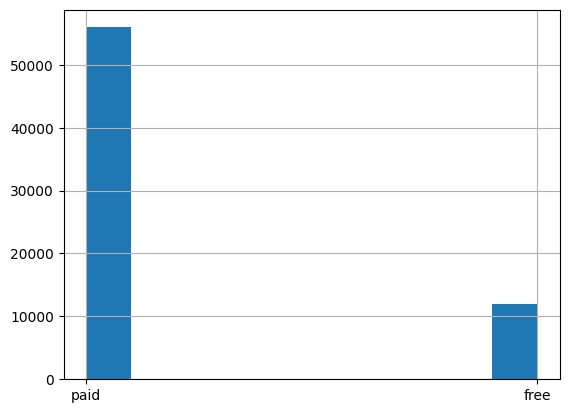

In [15]:
games_filtered['Price Category'].hist()
print(games_filtered['Price Category'].value_counts())


##### Feature importance with Randomforest regressor

In [16]:
# Encode the categorical columns

# Split the dataset into features (X) and target (y)
X = games_filtered.drop(['Peak CCU'], axis=1)
y = games_filtered['Peak CCU']

# Convert 'Release date' to datetime, coerce errors to NaT
#X['Release Year'] = pd.to_datetime(X['Release date'], errors='coerce').dt.year

# Fill missing 'Release Year' with the median of the available years
median_year = X['Release year'].median()
X['Release year'] = X['Release year'].fillna(median_year)

# Drop the original 'Release date' column as it's no longer needed
#X.drop(['Release date'], axis=1, inplace=True)

# Define categorical columns for one-hot encoding
categorical_features = ['Categories', 'Genres', 'Price Category']

# Encode 'Price Category' as a feature for now to determine its importance
X['Price Category'] = games_filtered['Price Category'].map({'free': 0, 'paid': 1})

# Define the ColumnTransformer to handle categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ], remainder='passthrough')


In [17]:
# Randomforest regressor model

# Create the RandomForestRegressor model within a pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=123))
])

# Splitting the dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Fit the model
model.fit(X_train, y_train)

# Get feature importances from the model (adjusting for the one-hot encoded features)
ohe_feature_names = model.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_features)
remainder_feature_names = np.array(X.drop(categorical_features, axis=1).columns)

# Combine all feature names
all_feature_names = np.concatenate([ohe_feature_names, remainder_feature_names])

# Get feature importances
feature_importances = model.named_steps['regressor'].feature_importances_

# Map importances to feature names
importances = pd.Series(feature_importances, index=all_feature_names).sort_values(ascending=False)

# Display the feature importances
print(importances)

Price                                                                                                                                                                                                                            0.139359
Release year                                                                                                                                                                                                                     0.056827
Genres_Action,Adventure,Casual,Indie,Racing,Strategy,Early Access                                                                                                                                                                0.051477
Categories_Single-player,Multi-player,PvP,Online PvP,Shared/Split Screen PvP,Co-op,Online Co-op,Shared/Split Screen Co-op,Shared/Split Screen,Steam Achievements,Full controller support,Steam Cloud                             0.049764
Average playtime forever                                        

In [18]:
# Map these importances to the corresponding feature names
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, importances))

# Convert to a pandas series for easy visualization and manipulation
feature_importances_series = pd.Series(feature_importance_dict).sort_values(ascending=False)

# Display the feature importances
print(feature_importances_series)

Required age                  0.139359
Price                         0.056827
DLC count                     0.051477
Average playtime forever      0.049764
Average playtime two weeks    0.042356
Median playtime forever       0.041689
Median playtime two weeks     0.034509
Categories                    0.033760
Genres                        0.032846
Release year                  0.029659
Price Category                0.029110
dtype: float64


Confounders:

Required age, DLC count, Average playtime forever, verage playtime two weeks, Median playtime forever, Median playtime two weeks, Categories, Genres, Release year

##### Model implementation

In [19]:
games_filtered

,Peak CCU,Required age,Price,DLC count,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Categories,Genres,Release year,Price Category
0,0.0,0.0,19.99,0.0,0.0,0.0,0.0,0.0,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports",2008,paid
1,0.0,0.0,0.99,0.0,0.0,0.0,0.0,0.0,"Single-player,Steam Achievements,Full controll...","Action,Indie",2017,paid
2,0.0,0.0,4.99,0.0,0.0,0.0,0.0,0.0,Single-player,"Action,Adventure,Indie,Strategy",2021,paid
3,0.0,0.0,5.99,0.0,0.0,0.0,0.0,0.0,"Single-player,Full controller support","Adventure,Casual,Indie",2020,paid
4,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,"Single-player,Steam Achievements","Adventure,Indie",2020,free
...,...,...,...,...,...,...,...,...,...,...,...,...
71711,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,"Single-player,Multi-player,PvP,Online PvP,Stea...","Free to Play,Indie,Massively Multiplayer,Strat...",2023,free
71712,6.0,0.0,10.79,0.0,0.0,0.0,0.0,0.0,"Single-player,Multi-player,PvP,Online PvP,Co-o...","Casual,Indie,RPG,Simulation,Strategy",2023,paid
71713,0.0,0.0,5.99,0.0,0.0,0.0,0.0,0.0,Single-player,"Casual,Simulation,Early Access",2023,paid
71714,0.0,0.0,2.39,0.0,0.0,0.0,0.0,0.0,Single-player,"Action,Casual,Indie,RPG,Early Access",2023,paid


In [20]:
from causalml.inference.meta import BaseRRegressor
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from causalml.inference.tree import UpliftRandomForestClassifier

# Encode categorical variables
le = LabelEncoder()
games_filtered['Categories'] = le.fit_transform(games_filtered['Categories'])
games_filtered['Genres'] = le.fit_transform(games_filtered['Genres'])

# Encode 'Price Category' as binary
games_filtered['Price Category'] = games_filtered['Price Category'].apply(lambda x: 0 if x == 'free' else 1)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
Failed to import duecredit due to No module named 'duecredit'


##### Handling imbalanced data

In [25]:
# count the number of Price Category = 1 and 0
games_filtered['Price Category'].value_counts()

1    55962
0    11894
Name: Price Category, dtype: int64

In [26]:
# Define the treatment, outcome, and confounders
treatment = 'Price Category'
outcome = 'Peak CCU'
confounders = ['Required age', 'DLC count', 'Average playtime forever', 'Average playtime two weeks', 
               'Median playtime forever', 'Median playtime two weeks', 'Categories', 'Genres', 'Release year']

# Prepare the data
X = games_filtered[confounders]
y = games_filtered[outcome]
treatment_binary = games_filtered[treatment].apply(lambda x: 1 if x == 'free' else 0).values


In [27]:
# Directly assign 'Price Category' to 'treatment_binary' if it's already in the correct form
treatment_binary = games_filtered['Price Category'].values

# Perform logistic regression to calculate propensity scores
logistic = LogisticRegression()
X_scaled = StandardScaler().fit_transform(X)
logistic.fit(X_scaled, treatment_binary)
propensity_scores = logistic.predict_proba(X_scaled)[:, 1]

In [31]:
# Check for missing values in each column
missing_values = causal_df.isnull().sum()
print("Missing values in each column:")
print(missing_values)

# Handling missing values
causal_df_cleaned = causal_df.dropna()

causal_df['outcome'].fillna(causal_df['outcome'].median(), inplace=True)

# Re-check for missing values after handling
missing_values_after = causal_df.isnull().sum()
print("\nMissing values after handling:")
print(missing_values_after)


Missing values in each column:
Required age                     0
DLC count                        0
Average playtime forever         0
Average playtime two weeks       0
Median playtime forever          0
Median playtime two weeks        0
Categories                       0
Genres                           0
Release year                     0
treatment                        0
propensity_score                 0
outcome                       3781
dtype: int64

Missing values after handling:
Required age                  0
DLC count                     0
Average playtime forever      0
Average playtime two weeks    0
Median playtime forever       0
Median playtime two weeks     0
Categories                    0
Genres                        0
Release year                  0
treatment                     0
propensity_score              0
outcome                       0
dtype: int64


In [29]:
# Match treatment and control groups based on propensity scores
from causalinference import CausalModel
from sklearn.model_selection import train_test_split

# Prepare data for CausalModel
causal_df = pd.DataFrame(X_scaled, columns=confounders)
causal_df['treatment'] = treatment_binary
causal_df['propensity_score'] = propensity_scores
causal_df['outcome'] = y

# Initialize CausalModel
causal = CausalModel(
    Y=causal_df['outcome'].values, 
    D=causal_df['treatment'].values, 
    X=causal_df['propensity_score'].values
)



In [30]:
# Estimate the Average Treatment Effect (ATE)
causal.est_via_matching(matches=1, bias_adj=True)
print(causal.estimates)


`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.



Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE        nan        nan        nan        nan        nan        nan
           ATC        nan        nan        nan        nan        nan        nan
           ATT        nan        nan        nan        nan        nan        nan



In [32]:
# Estimate the CATE
causal.est_propensity_s()
print(causal.propensity)



Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
     Intercept    -17.787      0.456    -39.042      0.000    -18.680    -16.894
            X0     43.362      1.193     36.349      0.000     41.023     45.700
         X0*X0    -23.463      0.768    -30.559      0.000    -24.968    -21.958



##### Permutation importance - Testing set

In [33]:
from causalml.inference.meta import BaseRRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


# Perform logistic regression to calculate propensity scores
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()
X_scaled = StandardScaler().fit_transform(X)
logistic.fit(X_scaled, treatment_binary)
propensity_scores = logistic.predict_proba(X_scaled)[:, 1]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test, treatment_train, treatment_test = train_test_split(
    X_scaled, y, treatment_binary, test_size=0.2, random_state=123)


In [34]:
# Initialize and fit the causal inference model
model_causal = BaseRRegressor(learner=RandomForestRegressor(random_state=123))
model_causal.fit(X=X_train, treatment=treatment_train, y=y_train)

# Function to calculate permutation importance for a causal model
def get_importance(model, X, y, treatment, n_repeats=10, random_state=42):
    rng = np.random.RandomState(random_state)
    baseline_ate = model.estimate_ate(X=X, treatment=treatment, y=y)[0]
    scores = np.zeros((X.shape[1], n_repeats))
    
    for n in range(n_repeats):
        for col in range(X.shape[1]):
            X_permuted = X.copy()
            shuffled_values = X_permuted[:, col]
            rng.shuffle(shuffled_values)
            X_permuted[:, col] = shuffled_values
            permuted_ate = model.estimate_ate(X=X_permuted, treatment=treatment, y=y)[0]
            scores[col, n] = np.abs(baseline_ate - permuted_ate)
    
    importance_means = scores.mean(axis=1)
    importance_stds = scores.std(axis=1)
    
    # Use 'confounders' list if available; otherwise, adapt as needed to match column names
    importance_df = pd.DataFrame({'Feature': confounders, 'Importance': importance_means, 'Std': importance_stds})
    return importance_df.sort_values(by='Importance', ascending=False)

# Evaluating feature importance on the test set
importance_df = get_importance(model_causal, X_test, y_test, treatment_test, n_repeats=10, random_state=123)
print(importance_df)

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

did not converge


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

                      Feature    Importance            Std
1                   DLC count  70767.516931  212286.865341
6                  Categories      3.713334       1.034890
0                Required age      2.793846       1.038364
5   Median playtime two weeks      2.385009       1.416827
2    Average playtime forever      2.271867       1.652259
4     Median playtime forever      1.813895       0.733597
3  Average playtime two weeks      1.800907       1.059316
8                Release year      1.235930       0.949690
7                      Genres      1.082884       1.232343


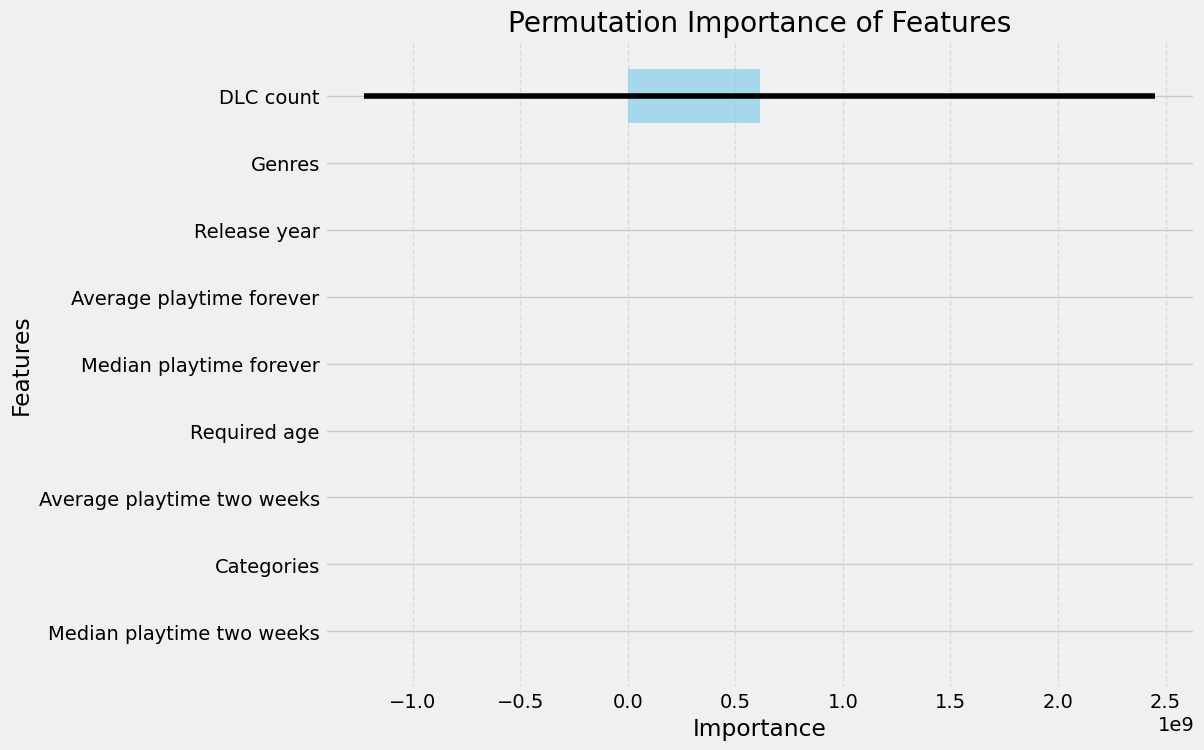

In [45]:
# visualize the permutation importance

# Sort the DataFrame by importance for better visualization
importance_df_sorted = importance_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 8))

# Plotting the bar chart
y_positions = np.arange(len(importance_df_sorted['Feature']))
plt.barh(y_positions, importance_df_sorted['Importance'], xerr=importance_df_sorted['Std'], align='center', alpha=0.7, color='skyblue')
plt.yticks(y_positions, importance_df_sorted['Feature'])

plt.title('Permutation Importance of Features')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.show()


##### Permutation importance - Training set

In [46]:
# Perform logistic regression to calculate propensity scores
logistic = LogisticRegression()
X_scaled = StandardScaler().fit_transform(X)
logistic.fit(X_scaled, treatment_binary)
propensity_scores = logistic.predict_proba(X_scaled)[:, 1]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test, treatment_train, treatment_test = train_test_split(
    X_scaled, y, treatment_binary, test_size=0.2, random_state=123)

# Initialize and fit the causal inference model
model_causal = BaseRRegressor(learner=RandomForestRegressor(random_state=123))
model_causal.fit(X=X_train, treatment=treatment_train, y=y_train)

# Function to calculate permutation importance for a causal model using the training set
def get_importance(model, X, y, treatment, n_repeats=10, random_state=42):
    rng = np.random.RandomState(random_state)
    baseline_ate = model.estimate_ate(X=X, treatment=treatment, y=y)[0]
    scores = np.zeros((X.shape[1], n_repeats))
    
    for n in range(n_repeats):
        for col in range(X.shape[1]):
            X_permuted = X.copy()
            shuffled_values = X_permuted[:, col]
            rng.shuffle(shuffled_values)
            X_permuted[:, col] = shuffled_values
            permuted_ate = model.estimate_ate(X=X_permuted, treatment=treatment, y=y)[0]
            scores[col, n] = np.abs(baseline_ate - permuted_ate)
    
    importance_means = scores.mean(axis=1)
    importance_stds = scores.std(axis=1)
    
    importance_df = pd.DataFrame({'Feature': confounders, 'Importance': importance_means, 'Std': importance_stds})
    return importance_df.sort_values(by='Importance', ascending=False)

# Evaluating feature importance on the training set
importance_df = get_importance(model_causal, X_train, y_train, treatment_train, n_repeats=10, random_state=123)

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

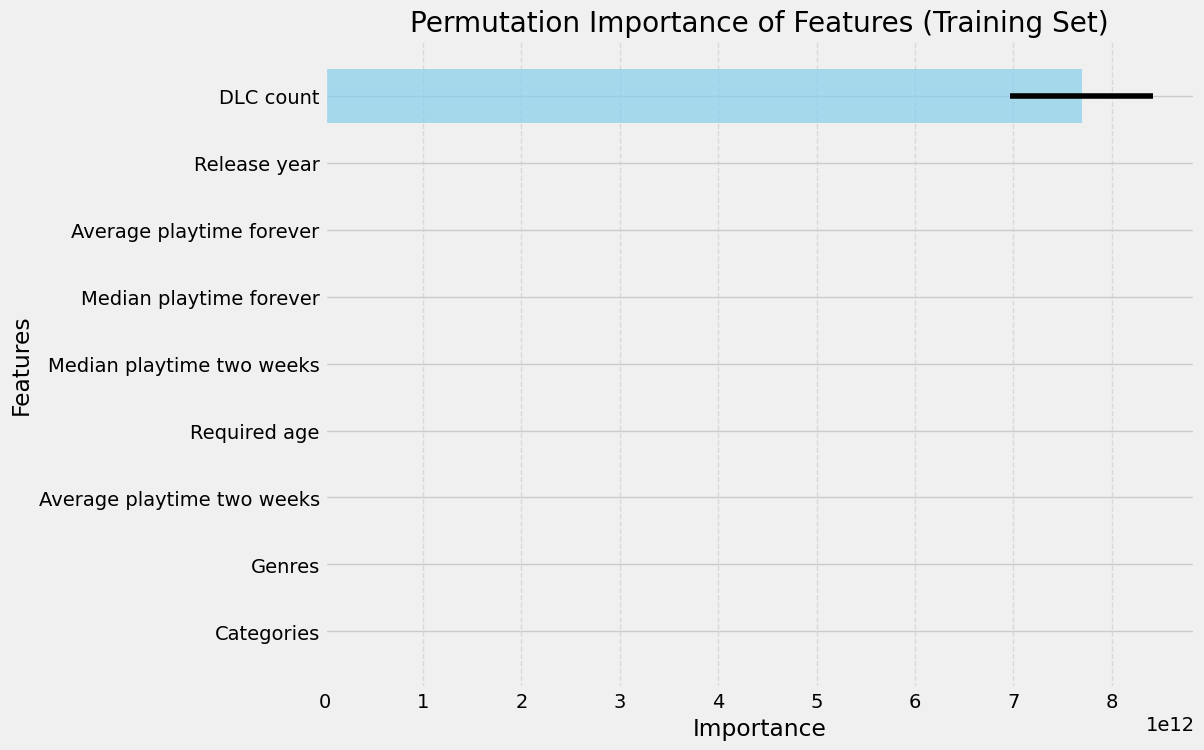

In [47]:
# Visualize the permutation importance based on the training set

# Sort the DataFrame by importance for better visualization
importance_df_sorted = importance_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 8))

# Plotting the bar chart
y_positions = np.arange(len(importance_df_sorted['Feature']))
plt.barh(y_positions, importance_df_sorted['Importance'], xerr=importance_df_sorted['Std'], align='center', alpha=0.7, color='skyblue')
plt.yticks(y_positions, importance_df_sorted['Feature'])

plt.title('Permutation Importance of Features (Training Set)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.show()

##### S-Learner

In [35]:
# Fill NaN values and check for infinite values
X_filled = X.fillna(X.mean())
np.any(np.isinf(X_filled))

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filled)  # Use X_filled to ensure no NaN values

logistic = LogisticRegression()
logistic.fit(X_scaled, treatment_binary)
propensity_scores = logistic.predict_proba(X_scaled)[:, 1]

# Adjust propensity scores slightly to avoid exact 0 or 1 values
epsilon = 1e-6
propensity_scores = np.clip(propensity_scores, epsilon, 1-epsilon)


In [36]:
from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseRRegressor
from sklearn.ensemble import RandomForestRegressor

# S-Learner
learner_s = BaseSRegressor(learner=RandomForestRegressor(random_state=123))
ate_s = learner_s.estimate_ate(X=X, treatment=treatment_binary, y=y)
print(f"ATE estimate (S-Learner): {ate_s[0]}")


ATE estimate (S-Learner): 0.1794521063256094


invalid value encountered in divide


In [37]:
# Fit the S-Learner and predict CATE
learner_s.fit(X=X, treatment=treatment_binary, y=y)
cate_s = learner_s.predict(X)
cate_s

array([[-3.54016667e+01],
       [ 2.56767732e-01],
       [-3.43495056e-02],
       ...,
       [ 0.00000000e+00],
       [ 4.25000000e-02],
       [ 1.15278535e+00]])

##### T-Learner

In [38]:
# T-Learner
learner_t = BaseTRegressor(control_learner=RandomForestRegressor(random_state=123),
                           treatment_learner=RandomForestRegressor(random_state=123))
ate_t = learner_t.estimate_ate(X=X, treatment=treatment_binary, y=y)
print(f"ATE estimate (T-Learner): {ate_t[0]}")


ATE estimate (T-Learner): [0.91890154]


invalid value encountered in divide


In [39]:
# Fit the T-Learner and predict CATE
learner_t.fit(X=X, treatment=treatment_binary, y=y)
cate_t = learner_t.predict(X)
cate_t

array([[-2.08360238e+01],
       [ 2.16857143e-01],
       [ 1.79480902e-03],
       ...,
       [ 4.00000000e-02],
       [ 3.75000000e-02],
       [ 1.17025580e+00]])

##### R-Learner

In [40]:
# R-Learner
learner_r = BaseRRegressor(learner=RandomForestRegressor(random_state=123))
ate_r = learner_r.estimate_ate(X=X, treatment=treatment_binary, y=y)
print(f"ATE estimate (R-Learner): {ate_r[0]}")

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

ATE estimate (R-Learner): [-1.91351878]


In [41]:
# Fit the R-Learner and predict CATE
learner_r.fit(X=X, treatment=treatment_binary, y=y)
cate_r = learner_r.predict(X)
cate_r

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

array([[-63.43341   ],
       [ -4.99594298],
       [ -0.12751907],
       ...,
       [ -1.33113492],
       [ -3.88811586],
       [  1.22987965]])

In [42]:
from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseRRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Splitting the data into training and testing sets with checked data
X_train, X_test, y_train, y_test, treatment_train, treatment_test = train_test_split(
    X_scaled, y, treatment_binary, test_size=0.2, random_state=123)

# Initialize and fit S-Learner
learner_s = BaseSRegressor(learner=RandomForestRegressor(random_state=123))
ate_s = learner_s.estimate_ate(X=X_train, treatment=treatment_train, y=y_train)
print(f"ATE estimate (S-Learner): {ate_s[0]}")

# Initialize and fit T-Learner
learner_t = BaseTRegressor(control_learner=RandomForestRegressor(random_state=123),
                           treatment_learner=RandomForestRegressor(random_state=123))
ate_t = learner_t.estimate_ate(X=X_train, treatment=treatment_train, y=y_train)
print(f"ATE estimate (T-Learner): {ate_t[0]}")

# Initialize and fit R-Learner
learner_r = BaseRRegressor(learner=RandomForestRegressor(random_state=123))
ate_r = learner_r.estimate_ate(X=X_train, treatment=treatment_train, y=y_train)
print(f"ATE estimate (R-Learner): {ate_r[0]}")


invalid value encountered in divide


ATE estimate (S-Learner): 0.11821714292881344


invalid value encountered in divide


ATE estimate (T-Learner): [0.66695347]


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

ATE estimate (R-Learner): [-2.39821571]


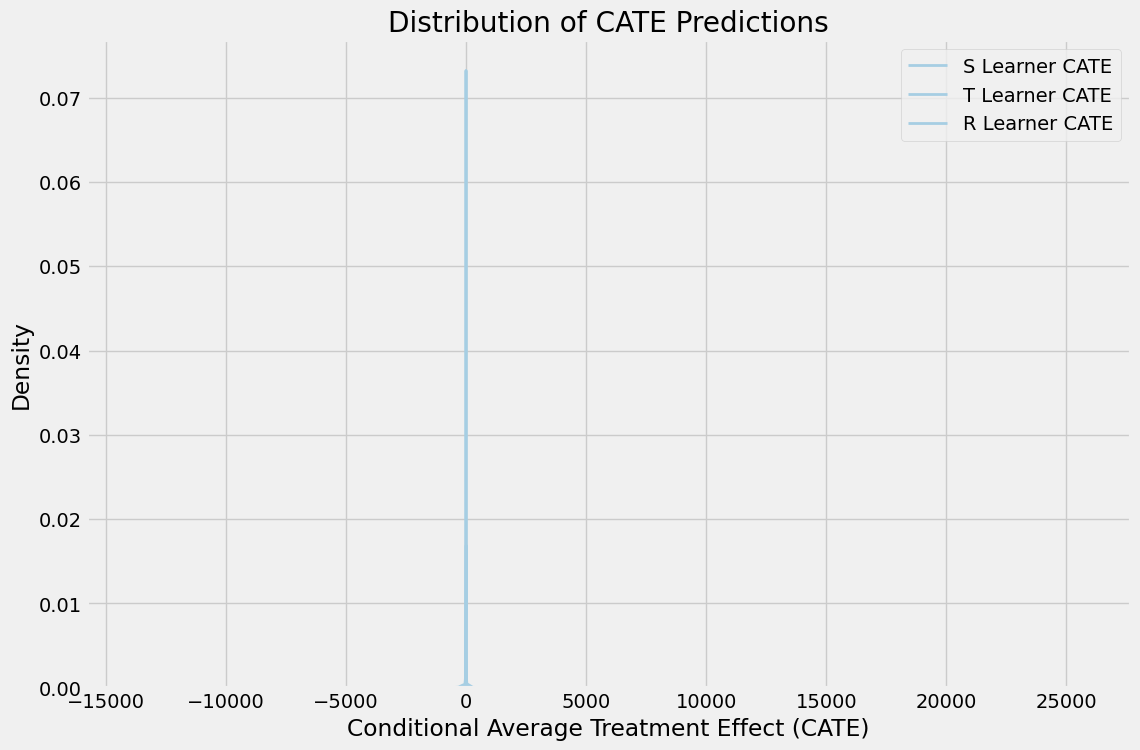

In [43]:
# Visualizing CATE Distributions
plt.figure(figsize=(12, 8))
sns.kdeplot(cate_s, label='S Learner CATE', color='blue', linewidth=2)
sns.kdeplot(cate_t, label='T Learner CATE', color='green', linewidth=2)
sns.kdeplot(cate_r, label='R Learner CATE', color='black', linewidth=2)

plt.title('Distribution of CATE Predictions')
plt.xlabel('Conditional Average Treatment Effect (CATE)')
plt.ylabel('Density')
plt.legend()
plt.show()

##### SHAP Value

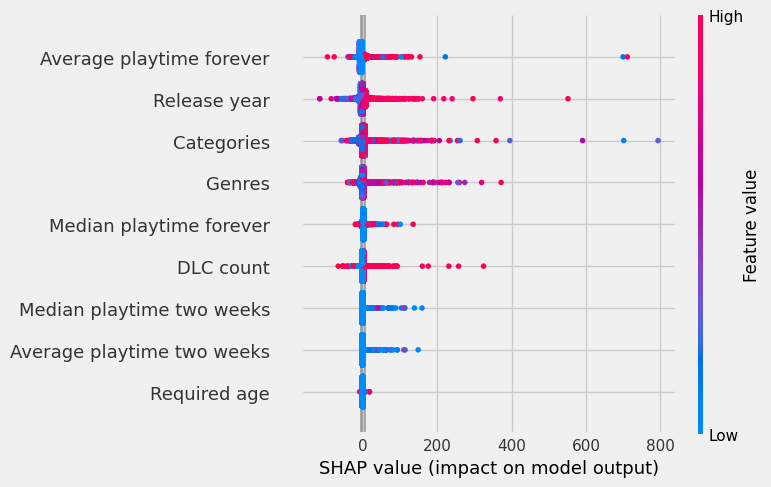

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [45]:
from sklearn.ensemble import RandomForestRegressor
import shap

model_rf = RandomForestRegressor(random_state=123)
model_rf.fit(X_train, y_train)  # Fit using the same training data

# Initialize the SHAP Explainer with the manually fitted model
explainer = shap.TreeExplainer(model_rf)

# Calculate SHAP values for the training data
shap_values = explainer.shap_values(X_train)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_train, feature_names=confounders)


##### Experiment for causal inference question:
What is the effect of a game offered "free" on the amount of peak concurrent users 

- Target: "Peak CCU"
- Treatment: "Price Category == free"
- Control: "Price Category == paid"
- confounders: "Required age", "DLC count", "Average playtime forever", "Average playtime two weeks", "Median playtime forever", "Median playtime two weeks", "Categories", "Genres", "Release year"

##### Model fitting:

- LRSRegressor: Fit a linear regression model to estimate the causal effect of the treatment on the target variable (Peak CCU). Use the confounders as control variables in your regression model.

- XGBTRegressor: Use XGBoost to model the same relationship, which can capture non-linear effects and interactions between variables more effectively than linear models.

##### LRSRegressor

In [48]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np


X = games_filtered[['Required age', 'DLC count', 'Average playtime forever', 'Average playtime two weeks', 
                    'Median playtime forever', 'Median playtime two weeks', 'Categories', 'Genres', 'Release year']]
# Convert categorical variables to dummy variables
X = pd.get_dummies(X, columns=['Categories', 'Genres'])

# Add treatment variable as a feature for regression
X['treatment'] = np.where(games_filtered['Price Category'] == 'free', 1, 0)

y = games_filtered['Peak CCU']

# Fit the linear regression model
model_lr = LinearRegression()
model_lr.fit(X, y)

# Coefficients
print("Treatment coefficient (Linear Regression):", model_lr.coef_[-1])  


Treatment coefficient (Linear Regression): 0.0


XGBTRegressor

[20:59:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

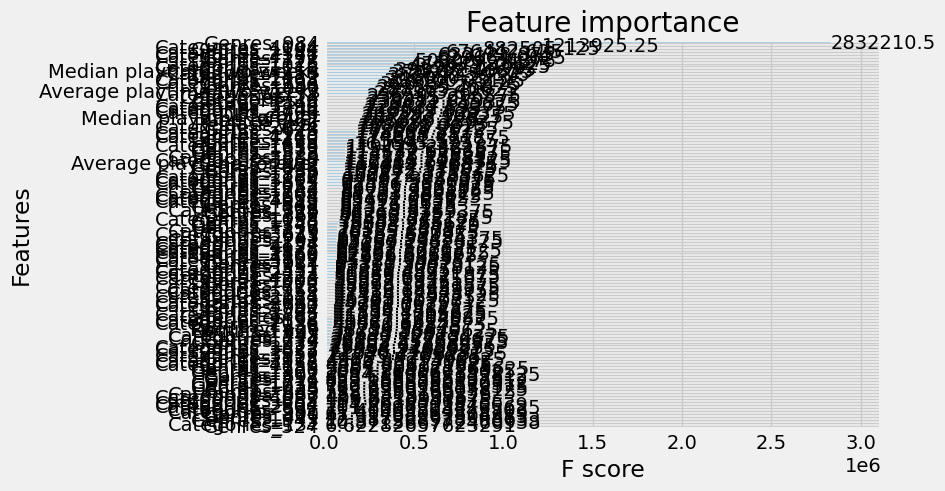

In [49]:
import xgboost as xgb

# Prepare the data (X has already been prepared for the linear model, including the treatment variable)
dtrain = xgb.DMatrix(X, label=y)

# Define parameters for XGBoost
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'learning_rate': 0.1,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'n_estimators': 100
}

# Train the model
model_xgb = xgb.train(params, dtrain, num_boost_round=100)

# Feature importance for understanding the impact of variables
xgb.plot_importance(model_xgb, importance_type='gain')


##### Model performance comparison

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

# Assuming 'games_filtered' is your DataFrame
X = games_filtered[['Required age', 'DLC count', 'Average playtime forever', 'Average playtime two weeks', 
                    'Median playtime forever', 'Median playtime two weeks', 'Categories', 'Genres', 'Release year']]
y = games_filtered['Peak CCU']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Define columns that need one-hot encoding
categorical_features = ['Categories', 'Genres']

# Create a column transformer with OneHotEncoder for categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ], remainder='passthrough')

# Apply preprocessing to training and test data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


In [53]:
# Fit Linear Regression Model
model_lr = LinearRegression()
model_lr.fit(X_train_processed, y_train)

# Predict and Evaluate Linear Regression
y_pred_lr = model_lr.predict(X_test_processed)

# XGBoost Model
dtest = xgb.DMatrix(X_test_processed, label=y_test) 


In [56]:
import matplotlib.pyplot as plt

treatment_effect_lr = model_lr.coef_[-1]

print(f"Treatment effect estimated by Linear Regression: {treatment_effect_lr}")


Treatment effect estimated by Linear Regression: 0.8512429219292634


In [58]:
# Extract feature importances
feature_importances = model_xgb.get_score(importance_type='weight')

treatment_effect_xgb = feature_importances.get('treatment', 0)

print(f"Feature importance for treatment from XGBoost: {treatment_effect_xgb}")


Feature importance for treatment from XGBoost: 0


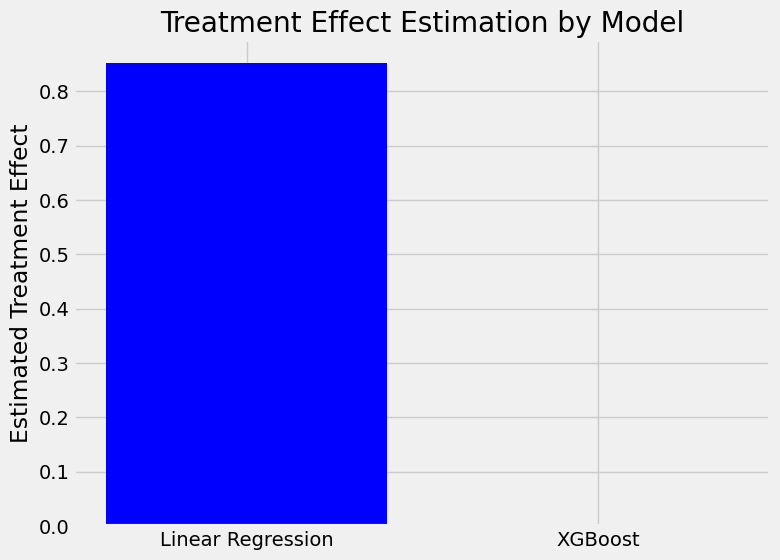

In [59]:
treatment_effects = [treatment_effect_lr, treatment_effect_xgb]
model_names = ['Linear Regression', 'XGBoost']

plt.figure(figsize=(8, 6))
plt.bar(model_names, treatment_effects, color=['blue', 'green'])
plt.ylabel('Estimated Treatment Effect')
plt.title('Treatment Effect Estimation by Model')
plt.show()


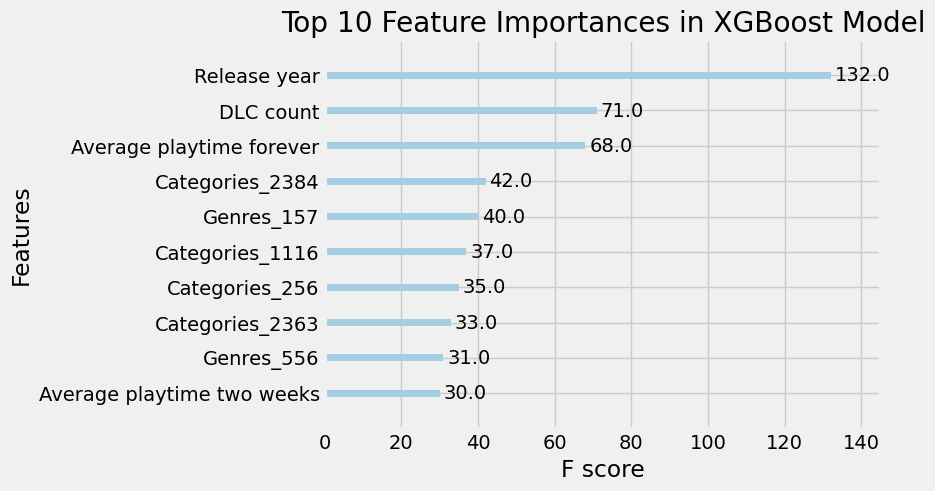

In [60]:
import xgboost as xgb
import matplotlib.pyplot as plt

xgb.plot_importance(model_xgb, importance_type='weight', max_num_features=10)
plt.title('Top 10 Feature Importances in XGBoost Model')
plt.show()
